<a href="https://colab.research.google.com/github/Jeongho-K/Car-model-classification/blob/main/code/2_Car_classification_with_EfficientNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 한글폰트 설치(런타임 재실행)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6863538121801667062
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12610278894040276323
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
# 한글폰트 지정
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 차량 이미지 데이터 준비

data: https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=554

## 차량 방향 확인을 위한(for yolov4) 이미지 리스트 생성

In [ ]:
import shutil
import os
import cv2
import matplotlib.pyplot as plt
import glob

In [ ]:
def make_img_list(BASE_FOLDER, OUTPUT):
    f_list = []
    for model_name in os.listdir(BASE_FOLDER):
        model_path = os.path.join(BASE_FOLDER, model_name)
        for detail_forder in os.listdir(model_path):
            folder_path = os.path.join(model_path, detail_forder + '/*')
            f_list += glob.glob(folder_path)

    with open(OUTPUT, 'w', encoding="UTF8") as f:
        for line in f_list:
            f.write(line)
            f.write('\n')

In [ ]:
train_BASE_FOLDER = r"/content/drive/MyDrive/Car-model-classification/data/1.Training/원천데이터/HY_현대"
train_OUTPUT = '/content/drive/MyDrive/Car-model-classification/data/train_image_list.txt'

make_img_list(train_BASE_FOLDER, train_OUTPUT)

In [ ]:
val_BASE_FOLDER = r"/content/drive/MyDrive/Car-model-classification/data/2.Validation/원천데이터/HY_현대"
val_OUTPUT = '/content/drive/MyDrive/Car-model-classification/data/val_image_list.txt'

make_img_list(val_BASE_FOLDER, val_OUTPUT)

## yolov4 custom(차량 앞, 뒤, 옆 분류)

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15502, done.
remote: Total 15502 (delta 0), reused 0 (delta 0), pack-reused 15502
Receiving objects: 100% (15502/15502), 14.17 MiB | 15.10 MiB/s, done.
Resolving deltas: 100% (10405/10405), done.


- darknet모델내 makefile파일 내용 수정  
- GPU=1, CUDNN=1, OPENCV=1

In [ ]:
import os
path = '/content/darknet'
os.chdir(path)
!make

In [ ]:
# verify installation
!./darknet

usage: ./darknet <function>


In [ ]:
# pretrained weights
import shutil
shutil.copy('/content/drive/MyDrive/Car-model-classification/models/YOLOv4_사전학습/yolov4-car.cfg', 'cfg/yolov4-car.cfg')
shutil.copy('/content/drive/MyDrive/Car-model-classification/models/YOLOv4_사전학습/yolov4-car_best.weights', 'cfg/yolov4-car_best.weights')
shutil.copy('/content/drive/MyDrive/Car-model-classification/models/YOLOv4_사전학습/car.names', 'data/car.names')
shutil.copy('/content/drive/MyDrive/Car-model-classification/models/YOLOv4_사전학습/car.data', 'data/car.data')

'data/car.data'

In [ ]:
!./darknet detector test data/car.data cfg/yolov4-car.cfg cfg/yolov4-car_best.weights -dont_show -out /content/drive/MyDrive/Car-model-classification/data/train_direction_results.json < /content/drive/MyDrive/Car-model-classification/data/train_image_list.txt

In [ ]:
!./darknet detector test data/car.data cfg/yolov4-car.cfg cfg/yolov4-car_best.weights -dont_show -out /content/drive/MyDrive/Car-model-classification/data/val_direction_results.json < /content/drive/MyDrive/Car-model-classification/data/val_image_list.txt

### 차량 front, side, back label
yolo모델로 생성된 direction_results.json으로 방향 class별 3개 라벨 데이터 생성

## 이미지 crop 후 방향에 맞춰 이미지 저장

In [ ]:
import os
import json
import cv2
import numpy as np
import shutil

In [ ]:
# 텍스트 읽기
def read_text(file_path, encoding="utf-8"):
    text = None
    with open(file_path, 'r', encoding=encoding) as f:
        text = f.read()
    return text

In [ ]:
def load_json(json_path, encoding="utf-8"):
    return json.loads(read_text(json_path, encoding))

In [ ]:
def check_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [ ]:
# box 정보에 대해 margin 값만큼 확장함
def expand_box(box, margin, img_width = None, img_height = None):
    x = box["left"]
    y = box["top"]
    w = box["width"]
    h = box["height"]

    x = x - margin
    x = max(x, 0)
    y = y - margin
    y = max(y, 0)

    w = w + 2*margin
    if img_width and x + w > img_width:
        w = img_width - x
    
    h = h + 2*margin
    if img_height and y + h > img_height:
        h = img_height - y

    new_box = {
        "left": x, 
        "top": y,
        "width": w,
        "height": h
    }

    return new_box

In [ ]:
# 이미지 crop
def crop_image(image_np, box, margin = 0):
    if margin > 0:
        box = expand_box(box, margin)
       
    x1 = box["left"]
    y1 = box["top"]
    x2 = box["left"] + box["width"]
    y2 = box["top"] + box["height"]
    return image_np[y1:y2, x1:x2]

In [ ]:
# 한글 경로 지원
def imread( file_path ) :
    stream = open( file_path.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    np_array = np.asarray(bytes, dtype=np.uint8)
    return cv2.imdecode(np_array , cv2.IMREAD_UNCHANGED)

In [ ]:
# 한글 경로 지원
def imwrite(file_path, img, params=None):
    try: 
        ext = os.path.splitext(file_path)[1]
        result, n = cv2.imencode(ext, img, params)
        if result: 
            with open(file_path, mode='w+b') as f:
                n.tofile(f)
                return True
        else: 
            return False 
    except Exception as e: 
        print(e)
        return False

In [ ]:
# 전체 이미지 bbox가 있는 경우 crop하고 아닌경우는 그냥 방향정보에 따라 저장 
def crop_store_by_direction(direction_path, BASE_OUTPUT_FOLDER):
    dir_json = load_json(direction_path)

    for dir in dir_json:

        if len(dir['objects']) > 0:
            confidence = [x['confidence'] for x in dir['objects']]
            if max(confidence) < 0.5: # 최고 신뢰도가 0.5 미만이면 crop이미지에서 제외
                continue
            best_idx = confidence.index(max(confidence)) # 가장 신뢰도 높은 분류 class

            img_path = dir['filename']
            tmp_list = img_path.split('/')
            tmp_list[7] = '라벨링데이터'
            img_name = tmp_list[11]
            json_name = img_name.split('.')[0] + '.json'
            json_path = '/'.join(tmp_list[:-1]) + '/' + json_name

            img_json = load_json(json_path)
            object_list = img_json["learningDataInfo"]["objects"]
            
            for i in range(len(object_list)):
                if img_json["learningDataInfo"]["objects"][i]["classId"] == 'P00.차량전체':
                    # 차량 전체 bbox
                    box = {
                            "left": int(img_json["learningDataInfo"]["objects"][i]["left"]),
                            "top": int(img_json["learningDataInfo"]["objects"][i]["top"]),
                            "width": int(img_json["learningDataInfo"]["objects"][i]["width"]),
                            "height": int(img_json["learningDataInfo"]["objects"][i]["height"])
                            }

                    # 이미지 크롭
                    img = imread(img_path) # 이미지 로드
                    img = crop_image(img, box, 10)

                    # 방향 확인 후 해당 폴더에 저장
                    direction = dir['objects'][best_idx]['name']
                    output_folder = os.path.join(BASE_OUTPUT_FOLDER, direction)
                    check_folder(output_folder)
                    output_path = os.path.join(output_folder, str(img_name))

                    imwrite(output_path, img) # 이미지 저장

                    # 라벨링 데이터도 같이 이동
                    shutil.copyfile(json_path, os.path.join(output_folder, str(json_name)))

        print(dir['frame_id'])

In [ ]:
# train & validation img
train_val_direction_path = '/content/drive/MyDrive/Car-model-classification/data/train_direction_results.json'
train_val_output_folder = '/content/drive/MyDrive/Car-model-classification/data/cropimg/train_val'

crop_store_by_direction(train_val_direction_path, train_val_output_folder)

In [ ]:
# test img
test_direction_path = '/content/drive/MyDrive/Car-model-classification/data/val_direction_results.json'
test_output_folder = '/content/drive/MyDrive/Car-model-classification/data/cropimg/test'

crop_store_by_direction(test_direction_path, test_output_folder)

# 차량 분류 모델 학습전 import, 데이터 준비

## image dastaframe

In [ ]:
import pandas as pd
import json
import os

In [ ]:
# 텍스트 읽기
def read_text(file_path, encoding="utf-8"):
    text = None
    with open(file_path, 'r', encoding=encoding) as f:
        text = f.read()
    return text

In [ ]:
def load_json(json_path, encoding="utf-8"):
    return json.loads(read_text(json_path, encoding))

### save image dataframe

In [ ]:
def make_df(dataset_path, direction):
    base_path = os.path.join(dataset_path, direction)
    img_path = []
    brand = []
    model_year = []
    for files in os.listdir(base_path):
        if os.path.splitext(files)[1] == '.json':
            tmp_json = load_json(os.path.join(base_path, files))
            img_path.append(os.path.join(base_path, tmp_json['sourceDataInfo']['sourceDataID']+'.jpg'))
            brand.append(tmp_json['rawDataInfo']['MediumCategoryId'])
            model_year.append(tmp_json['rawDataInfo']['SmallCategoryId']+'_'+str(tmp_json['rawDataInfo']['yearId']))

    data = {
        'img_path':img_path,
        'brand':brand,
        'model_year':model_year
    }
    df = pd.DataFrame(data)
    return df

In [ ]:
base_dir = '/content/drive/MyDrive/Car-model-classification/data/cropimg'
train_val_dir = os.path.join(base_dir, 'train_val')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Setup the front Image df
train_val_front_df = make_df(train_val_dir, 'car_front')
test_front_df = make_df(test_dir, 'car_front')

In [ ]:
# Setup the side Image df
train_val_side_df = make_df(train_val_dir, 'car_side')
test_side_df = make_df(test_dir, 'car_side')

In [ ]:
# Setup the back Image df
train_val_back_df = make_df(train_val_dir, 'car_back')
test_back_df = make_df(test_dir, 'car_back')

### split train, validation dataframe

In [ ]:
# 각 차량 모델별 20%를 추출해 val_df로
def split_df(train_val_df):
    val_df = pd.DataFrame()
    for model_year in list(train_val_df['model_year'].unique()):
        sample_df = train_val_df[train_val_df['model_year'] == model_year].sample(frac=0.2)
        val_df = pd.concat([val_df, sample_df], ignore_index=True)

    train_df = pd.concat([train_val_df, val_df, val_df]).drop_duplicates(keep=False).reset_index()
    return train_df, val_df

In [ ]:
# split train, val
train_front_df, val_front_df = split_df(train_val_front_df)
train_side_df, val_side_df = split_df(train_val_side_df)
train_back_df, val_back_df = split_df(train_val_back_df)

#### Class 조정 전 dataframe

In [ ]:
print(len(train_front_df))
print(len(val_front_df))
print(len(test_front_df))
print()

print(len(train_side_df))
print(len(val_side_df))
print(len(test_side_df))
print()

print(len(train_back_df))
print(len(val_back_df))
print(len(test_back_df))

5827
1456
877

5336
1330
886

5109
1278
835


In [ ]:
def check_class(df):
    print(len(df['model_year'].unique()))
    print(df['model_year'].value_counts())
    print()

In [ ]:
check_class(train_front_df)
check_class(val_front_df)
check_class(test_front_df)

65
코나_2018      262
쏘나타_2019     207
그랜저_2018     205
아반떼_2018     202
그랜저_2019     199
            ... 
아이오닉_2021     17
넥쏘_2020       11
스타렉스_2021     11
벨로스터_2021     10
벨로스터_2017      7
Name: model_year, Length: 65, dtype: int64

65
코나_2018      66
쏘나타_2019     52
그랜저_2018     51
아반떼_2018     50
그랜저_2019     50
             ..
아이오닉_2021     4
벨로스터_2021     3
스타렉스_2021     3
넥쏘_2020       3
벨로스터_2017     2
Name: model_year, Length: 65, dtype: int64

64
쏘나타_2018     38
코나_2018      37
쏘나타_2019     37
그랜저_2019     30
코나_2019      29
             ..
벨로스터_2020     3
아이오닉_2019     3
베뉴_2019       2
코나_2021       2
벨로스터_2017     1
Name: model_year, Length: 64, dtype: int64



In [ ]:
check_class(train_side_df)
check_class(val_side_df)
check_class(test_side_df)

65
코나_2018      217
싼타페_2019     197
싼타페_2017     194
아반떼_2018     174
쏘나타_2018     173
            ... 
코나_2021       14
아이오닉_2021     13
i30_2019      12
벨로스터_2017     10
벨로스터_2021      6
Name: model_year, Length: 65, dtype: int64

65
코나_2018      54
싼타페_2019     49
싼타페_2017     49
아반떼_2018     43
쏘나타_2018     43
             ..
코나_2021       4
벨로스터_2017     3
아이오닉_2021     3
i30_2019      3
벨로스터_2021     1
Name: model_year, Length: 65, dtype: int64

65
쏘나타_2019     34
쏘나타_2018     33
그랜저_2018     32
싼타페_2019     31
그랜저_2019     27
             ..
벨로스터_2021     2
아이오닉_2018     2
아이오닉_2021     2
i30_2019      2
베뉴_2019       1
Name: model_year, Length: 65, dtype: int64



In [ ]:
check_class(train_back_df)
check_class(val_back_df)
check_class(test_back_df)

64
코나_2018      218
아반떼_2018     202
그랜저_2019     192
쏘나타_2019     172
싼타페_2019     170
            ... 
스타렉스_2021     10
포터2_2021       9
넥쏘_2020        8
벨로스터_2017      6
포터2_2020       3
Name: model_year, Length: 64, dtype: int64

64
코나_2018      54
아반떼_2018     51
그랜저_2019     48
쏘나타_2019     43
싼타페_2019     42
             ..
넥쏘_2020       2
포터2_2021      2
벨로스터_2021     2
포터2_2020      1
벨로스터_2017     1
Name: model_year, Length: 64, dtype: int64

62
코나_2018     34
싼타페_2019    34
아반떼_2017    31
아반떼_2018    31
쏘나타_2018    30
            ..
포터2_2017     2
코나_2021      2
넥쏘_2020      2
포터2_2021     1
포터2_2020     1
Name: model_year, Length: 62, dtype: int64



### 데이터셋 class조정

#### Class분류를 자동차 모델별 연식(생산된 연도, model_year)에서 연형(차량이 설계된 연도)으로 변경
차량 연식 확인: http://www.encar.com/index.do
자동차 연식과 연형의 차이: https://m.blog.naver.com/e_mobis/220859183791

In [ ]:
def value_replace(df1, df2, df3, year, age_type):
    df1["model_year"] = df1["model_year"].replace(year, age_type)
    df2["model_year"] = df2["model_year"].replace(year, age_type)
    df3["model_year"] = df3["model_year"].replace(year, age_type)
    return df1, df2, df3

In [ ]:
def hyundai_replace(train_df, val_df, test_df):
    value_replace(train_df, val_df, test_df, '팰리세이드_2019', '팰리세이드_2019-21')
    value_replace(train_df, val_df, test_df, '팰리세이드_2020', '팰리세이드_2019-21')
    value_replace(train_df, val_df, test_df, '팰리세이드_2021', '팰리세이드_2019-21')

    value_replace(train_df, val_df, test_df, '포터2_2017', '포터2_2017-21')
    value_replace(train_df, val_df, test_df, '포터2_2018', '포터2_2017-21')
    value_replace(train_df, val_df, test_df, '포터2_2019', '포터2_2017-21')
    value_replace(train_df, val_df, test_df, '포터2_2020', '포터2_2017-21')
    value_replace(train_df, val_df, test_df, '포터2_2021', '포터2_2017-21')

    value_replace(train_df, val_df, test_df, '투싼_2017', '투싼_2017-20')
    value_replace(train_df, val_df, test_df, '투싼_2018', '투싼_2017-20')
    value_replace(train_df, val_df, test_df, '투싼_2019', '투싼_2017-20')
    value_replace(train_df, val_df, test_df, '투싼_2020', '투싼_2017-20')

    value_replace(train_df, val_df, test_df, '코나_2017', '코나_2017-20')
    value_replace(train_df, val_df, test_df, '코나_2018', '코나_2017-20')
    value_replace(train_df, val_df, test_df, '코나_2019', '코나_2017-20')
    value_replace(train_df, val_df, test_df, '코나_2020', '코나_2017-20')

    value_replace(train_df, val_df, test_df, '아이오닉_2017', '아이오닉_2017-19')
    value_replace(train_df, val_df, test_df, '아이오닉_2018', '아이오닉_2017-19')
    value_replace(train_df, val_df, test_df, '아이오닉_2019', '아이오닉_2017-19')
    value_replace(train_df, val_df, test_df, '아이오닉_2020', '아이오닉_2020-21')
    value_replace(train_df, val_df, test_df, '아이오닉_2021', '아이오닉_2020-21')

    value_replace(train_df, val_df, test_df, '엑센트_2017', '엑센트_2017-19')
    value_replace(train_df, val_df, test_df, '엑센트_2018', '엑센트_2017-19')
    value_replace(train_df, val_df, test_df, '엑센트_2019', '엑센트_2017-19')

    value_replace(train_df, val_df, test_df, '아반떼_2017', '아반떼_2017-20')
    value_replace(train_df, val_df, test_df, '아반떼_2018', '아반떼_2017-20')
    value_replace(train_df, val_df, test_df, '아반떼_2019', '아반떼_2017-20')
    value_replace(train_df, val_df, test_df, '아반떼_2020', '아반떼_2017-20')

    value_replace(train_df, val_df, test_df, '쏘나타_2017', '쏘나타_2017-19')
    value_replace(train_df, val_df, test_df, '쏘나타_2018', '쏘나타_2017-19')
    value_replace(train_df, val_df, test_df, '쏘나타_2019', '쏘나타_2017-19')
    value_replace(train_df, val_df, test_df, '쏘나타_2020', '쏘나타_2020-21')
    value_replace(train_df, val_df, test_df, '쏘나타_2021', '쏘나타_2020-21')

    value_replace(train_df, val_df, test_df, '싼타페_2017', '싼타페_2017-18')
    value_replace(train_df, val_df, test_df, '싼타페_2018', '싼타페_2017-18')
    value_replace(train_df, val_df, test_df, '싼타페_2019', '싼타페_2019-20')
    value_replace(train_df, val_df, test_df, '싼타페_2020', '싼타페_2019-20')

    value_replace(train_df, val_df, test_df, '스타렉스_2017', '스타렉스_2017-21')
    value_replace(train_df, val_df, test_df, '스타렉스_2018', '스타렉스_2017-21')
    value_replace(train_df, val_df, test_df, '스타렉스_2019', '스타렉스_2017-21')
    value_replace(train_df, val_df, test_df, '스타렉스_2020', '스타렉스_2017-21')
    value_replace(train_df, val_df, test_df, '스타렉스_2021', '스타렉스_2017-21')

    value_replace(train_df, val_df, test_df, '베뉴_2019', '베뉴_2019-21')
    value_replace(train_df, val_df, test_df, '베뉴_2020', '베뉴_2019-21')
    value_replace(train_df, val_df, test_df, '베뉴_2021', '베뉴_2019-21')

    value_replace(train_df, val_df, test_df, '벨로스터_2017', '벨로스터_2017-18')
    value_replace(train_df, val_df, test_df, '벨로스터_2018', '벨로스터_2017-18')
    value_replace(train_df, val_df, test_df, '벨로스터_2019', '벨로스터_2019-21')
    value_replace(train_df, val_df, test_df, '벨로스터_2020', '벨로스터_2019-21')
    value_replace(train_df, val_df, test_df, '벨로스터_2021', '벨로스터_2019-21')

    value_replace(train_df, val_df, test_df, '그랜저_2017', '그랜저_2017-19')
    value_replace(train_df, val_df, test_df, '그랜저_2018', '그랜저_2017-19')
    value_replace(train_df, val_df, test_df, '그랜저_2019', '그랜저_2017-19')
    value_replace(train_df, val_df, test_df, '그랜저_2020', '그랜저_2020-21')
    value_replace(train_df, val_df, test_df, '그랜저_2021', '그랜저_2020-21')

    value_replace(train_df, val_df, test_df, '맥스크루즈_2017', '맥스크루즈_2017-18')
    value_replace(train_df, val_df, test_df, '맥스크루즈_2018', '맥스크루즈_2017-18')

    value_replace(train_df, val_df, test_df, 'i30_2017', 'i30_2017-19')
    value_replace(train_df, val_df, test_df, 'i30_2018', 'i30_2017-19')
    value_replace(train_df, val_df, test_df, 'i30_2019', 'i30_2017-19')

In [ ]:
hyundai_replace(train_front_df, val_front_df, test_front_df)
hyundai_replace(train_side_df, val_side_df, test_side_df)
hyundai_replace(train_back_df, val_back_df, test_back_df)

#### 차량 방향(front, side, back) 데이터셋 별 class 맞추기

In [ ]:
# 해당 열의 원하는 value list로만 df 필터
def df_filter_by_values(value_list, df):
    mask = df['model_year'].isin(value_list)
    df = df[mask]
    return df

In [ ]:
# 서로 같은 class를 가지도록 편집
def unique_class(train_df, val_df, test_df):
    train_set = set(train_df['model_year'].unique())
    val_set = set(val_df['model_year'].unique())
    test_set = set(test_df['model_year'].unique())

    unique_class = list(train_set & val_set & test_set)

    train_df = df_filter_by_values(unique_class, train_df)
    val_df = df_filter_by_values(unique_class, val_df)
    test_df = df_filter_by_values(unique_class, test_df)

    return train_df, val_df, test_df

In [ ]:
train_front_df, val_front_df, test_front_df = unique_class(train_front_df, val_front_df, test_front_df)
train_side_df, val_side_df, test_side_df = unique_class(train_side_df, val_side_df, test_side_df)
train_back_df, val_back_df, test_back_df = unique_class(train_back_df, val_back_df, test_back_df)

#### class내 이미지수가 50장 미만이 경우 제외

In [ ]:
# train_df 기준 value counts 값이 50보다 작은 경우 학습에 어려움이 있다고 판단하여 제외
def filter_class(train_df, val_df, test_df):
    sorted_df = train_df.groupby(['model_year'])['img_path'] \
                                .count() \
                                .reset_index(name='count') \
                                .sort_values(['count'], ascending=False)

    unique_class = list(sorted_df[sorted_df['count']>50].loc[:,'model_year'])

    train_df = df_filter_by_values(unique_class, train_df)
    val_df = df_filter_by_values(unique_class, val_df)
    test_df = df_filter_by_values(unique_class, test_df)

    return train_df, val_df, test_df

In [ ]:
train_front_df, val_front_df, test_front_df = filter_class(train_front_df, val_front_df, test_front_df)
train_side_df, val_side_df, test_side_df = filter_class(train_side_df, val_side_df, test_side_df)
train_back_df, val_back_df, test_back_df = filter_class(train_back_df, val_back_df, test_back_df)

### save dataframe

In [ ]:
# save to csv
base_path = '/content/drive/MyDrive/Car-model-classification/data'
train_front_df.to_csv(os.path.join(base_path, 'train_front_df.csv'))
val_front_df.to_csv(os.path.join(base_path, 'val_front_df.csv'))
test_front_df.to_csv(os.path.join(base_path, 'test_front_df.csv'))

train_side_df.to_csv(os.path.join(base_path, 'train_side_df.csv'))
val_side_df.to_csv(os.path.join(base_path, 'val_side_df.csv'))
test_side_df.to_csv(os.path.join(base_path, 'test_side_df.csv'))

train_back_df.to_csv(os.path.join(base_path, 'train_back_df.csv'))
val_back_df.to_csv(os.path.join(base_path, 'val_back_df.csv'))
test_back_df.to_csv(os.path.join(base_path, 'test_back_df.csv'))

## Imports

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

In [ ]:
def generate_dataset(train_df, val_df, test_df):
    '''
    image dataset 생성
    ImageDataGenerator  
    * rotation_range : 이미지회전값  
    * zoom_range : 이미지일부확대  
    * shear_range : 이미지기울기  
    * width_shift_range : 좌우이동  
    * height_shift_range : 상하이동  
    * horizontal_flip : 이미지가로뒤집기  
    * vertical_filp : 이미지세로뒤집기
    '''
    train_generator = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    fill_mode='nearest')

    test_generator = ImageDataGenerator(rescale = 1./255)

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='img_path',
        y_col='model_year',
        target_size=(width,height),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='img_path',
        y_col='model_year',
        target_size=(width,height),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='img_path',
        y_col='model_year',
        target_size=(width,height),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )
    return train_images, val_images, test_images

In [ ]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [ ]:
def plot_hist(hist, value):
    '''
    모델 학습 결과 확인 Plot
    '''
    plt.plot(hist.history[f"{value}"])
    plt.plot(hist.history[f"val_{value}"])
    plt.title(f"model {value}")
    plt.ylabel(f"{value}")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def plot_heatmap(model, image_set, class_num):
    '''
    plot haetmap
    '''
    predictions = np.argmax(model.predict(image_set), axis=1)

    cm = confusion_matrix(image_set.labels, predictions)

    plt.figure(figsize=(30, 30))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(class_num) + 0.5, labels=image_set.class_indices, rotation=90)
    plt.yticks(ticks=np.arange(class_num) + 0.5, labels=image_set.class_indices, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def show_cam(image_value, features, results, label):
    '''
    Displays the class activation map of an image
 
    Args:
        image_value (tensor) -- preprocessed input image with size 224 x 224
        features (array) -- features of the image, shape (1, 7, 7, 512)
        results (array) -- output of the sigmoid layer
    '''
    features_for_img = features[0]
    prediction = results[0]
 
    class_activation_weigths = gap_weights[:,label]
    class_activation_features = sp.ndimage.zoom(features_for_img, (224/7, 224/7, 1), order=2)
    cam_output = np.dot(class_activation_features, class_activation_weigths)
    cam_output = tf.reshape(cam_output, (224,224))
 
    # visualize the results
    print(f'sigmoid output: {results}')
    print(f"prediction: {'dog' if tf.argmax(results[0]) else 'cat'}")
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()

## load image dataframe

In [ ]:
# load csv
base_path = '/content/drive/MyDrive/Car-model-classification/data'
train_front_df = pd.read_csv(os.path.join(base_path, 'train_front_df.csv'))
val_front_df = pd.read_csv(os.path.join(base_path, 'val_front_df.csv'))
test_front_df = pd.read_csv(os.path.join(base_path, 'test_front_df.csv'))

train_side_df = pd.read_csv(os.path.join(base_path, 'train_side_df.csv'))
val_side_df = pd.read_csv(os.path.join(base_path, 'val_side_df.csv'))
test_side_df = pd.read_csv(os.path.join(base_path, 'test_side_df.csv'))

train_back_df = pd.read_csv(os.path.join(base_path, 'train_back_df.csv'))
val_back_df = pd.read_csv(os.path.join(base_path, 'val_back_df.csv'))
test_back_df = pd.read_csv(os.path.join(base_path, 'test_back_df.csv'))

In [ ]:
print(len(train_front_df))
print(len(val_front_df))
print(len(test_front_df))
print()

print(len(train_side_df))
print(len(val_side_df))
print(len(test_side_df))
print()

print(len(train_back_df))
print(len(val_back_df))
print(len(test_back_df))

5691
1422
849

5201
1296
861

4949
1238
801


In [ ]:
def check_class(df):
    print(len(df['model_year'].unique()))
    print(df['model_year'].value_counts())
    print()

In [ ]:
check_class(train_front_df)
check_class(val_front_df)
check_class(test_front_df)

20
아반떼_2017-20      612
코나_2017-20       584
그랜저_2017-19      525
쏘나타_2017-19      481
투싼_2017-20       410
포터2_2017-21      379
스타렉스_2017-21     350
싼타페_2019-20      268
팰리세이드_2019-21    256
쏘나타_2020-21      251
싼타페_2017-18      240
그랜저_2020-21      215
엑센트_2017-19      205
아이오닉_2017-19     192
베뉴_2019-21       168
i30_2017-19      167
벨로스터_2019-21     124
아반떼_2021         107
맥스크루즈_2017-18     88
싼타페_2021          69
Name: model_year, dtype: int64

20
아반떼_2017-20      153
코나_2017-20       147
그랜저_2017-19      131
쏘나타_2017-19      120
투싼_2017-20       102
포터2_2017-21       94
스타렉스_2017-21      87
싼타페_2019-20       67
팰리세이드_2019-21     64
쏘나타_2020-21       62
싼타페_2017-18       60
그랜저_2020-21       54
엑센트_2017-19       51
아이오닉_2017-19      48
베뉴_2019-21        43
i30_2017-19       41
벨로스터_2019-21      32
아반떼_2021          27
맥스크루즈_2017-18     22
싼타페_2021          17
Name: model_year, dtype: int64

20
아반떼_2017-20      90
코나_2017-20       83
쏘나타_2017-19      80
그랜저_2017-19      73
투싼_2017

In [ ]:
check_class(train_side_df)
check_class(val_side_df)
check_class(test_side_df)

20
아반떼_2017-20      560
스타렉스_2017-21     545
코나_2017-20       462
쏘나타_2017-19      408
그랜저_2017-19      406
투싼_2017-20       390
싼타페_2019-20      325
싼타페_2017-18      293
팰리세이드_2019-21    269
쏘나타_2020-21      243
그랜저_2020-21      197
엑센트_2017-19      164
포터2_2017-21      147
아이오닉_2017-19     144
베뉴_2019-21       141
i30_2017-19      115
아반떼_2021         109
벨로스터_2019-21     108
맥스크루즈_2017-18    105
싼타페_2021          70
Name: model_year, dtype: int64

20
아반떼_2017-20      139
스타렉스_2017-21     135
코나_2017-20       115
쏘나타_2017-19      102
그랜저_2017-19      102
투싼_2017-20        98
싼타페_2019-20       81
싼타페_2017-18       74
팰리세이드_2019-21     66
쏘나타_2020-21       61
그랜저_2020-21       49
엑센트_2017-19       41
포터2_2017-21       37
아이오닉_2017-19      37
베뉴_2019-21        34
i30_2017-19       29
아반떼_2021          27
벨로스터_2019-21      26
맥스크루즈_2017-18     26
싼타페_2021          17
Name: model_year, dtype: int64

20
쏘나타_2017-19      85
스타렉스_2017-21     83
그랜저_2017-19      83
아반떼_2017-20      80
투싼_2017

In [ ]:
check_class(train_back_df)
check_class(val_back_df)
check_class(test_back_df)

19
아반떼_2017-20      603
코나_2017-20       482
그랜저_2017-19      475
투싼_2017-20       449
쏘나타_2017-19      415
스타렉스_2017-21     300
싼타페_2019-20      288
팰리세이드_2019-21    287
싼타페_2017-18      264
쏘나타_2020-21      210
그랜저_2020-21      189
아이오닉_2017-19     168
엑센트_2017-19      149
베뉴_2019-21       142
i30_2017-19      132
벨로스터_2019-21     114
아반떼_2021         105
맥스크루즈_2017-18    103
싼타페_2021          74
Name: model_year, dtype: int64

19
아반떼_2017-20      152
코나_2017-20       121
그랜저_2017-19      119
투싼_2017-20       112
쏘나타_2017-19      103
스타렉스_2017-21      75
팰리세이드_2019-21     72
싼타페_2019-20       71
싼타페_2017-18       66
쏘나타_2020-21       53
그랜저_2020-21       47
아이오닉_2017-19      42
엑센트_2017-19       37
베뉴_2019-21        35
i30_2017-19       34
벨로스터_2019-21      28
아반떼_2021          26
맥스크루즈_2017-18     26
싼타페_2021          19
Name: model_year, dtype: int64

19
아반떼_2017-20      97
코나_2017-20       88
투싼_2017-20       71
그랜저_2017-19      67
쏘나타_2017-19      60
싼타페_2019-20      50
싼타페_2017-

# 이미지 전처리 후 모델링 실험 내용
1. 자동차 연형을 고려하지 않고 모델로 카테고리를 나눠서 진행
- 결과: accuracy가 epoch가 진행될 수록 증가하지만 낮은 증가율과 성능을 보임
- heatmap확인시 차량 모델이 연식에 따라 크게 변하는 경우 잘 분류해 내지 못함
- heatmap확인시 카테고리에 카테고리에 이미지가 적은 경우도(train 이미지 대략 50장) 잘 분류해 내지 못하는 것을 확인
2. 자동차 연형을 고려하기 위해 클래스별 더 많은 이미지가 필요하다고 생각하여 기존 'P00.차량전체' bounding box로 크롭한 이미지에 크롭하지 않은 이미지도 포함하여 진행
- 이미지를 확인해본 결과 먼 거리에서 차량을 찍은 이미지와 너무 가까운 거리에서 차량을 찍은 이미지가 포함된 것을 확인
- 해당 이미지 셋으로 학습을 진행해 보았지만 0.2에서 epoch를 늘려도 더이상 학습이 진행되지 않아 학습을 완료하지 않고 중단
3. 앞의 두 실험결과를 바탕으로 이미지를 나눌 카테고리는 model명_연형으로 하고 'P00.차량전체' bounding box로 크롭한 이미지만 사용, 각 카테고리는 각 train 이미지가 50장 이상이 경우만 학습 진행, front, side, back에 맞는지 직접 확인해 재분류 진행

# efficientnetv2B0 vs efficientnetv2S
front image만 비교

## efficientnetv2B0 car front images

### Hyper parameters

https://pypi.org/project/keras-efficientnet-v2/

In [ ]:
front_class_num = 20
batch_size = 32

width = 224
height = 224
epochs = 30
dropout_rate = 0.2
input_shape = (height, width, 3)

### image dataset

In [ ]:
train_front_images, val_front_images, test_front_images = generate_dataset(train_front_df, val_front_df, test_front_df)

Found 5691 validated image filenames belonging to 20 classes.
Found 1422 validated image filenames belonging to 20 classes.
Found 849 validated image filenames belonging to 20 classes.


### load the conv base model (efficientNetV2B0)

In [ ]:
inputs = tf.keras.Input(shape = input_shape)
x = tf.keras.applications.EfficientNetV2B0(include_top = False, weights = 'imagenet')(inputs)
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dropout(dropout_rate, name="dropout_out")(x)
outputs = layers.Dense(front_class_num, activation='softmax', name="fc_out")(x)

efnv2b0_model = tf.keras.Model(inputs, outputs)

24274472/24274472 [==============================] - 1s 0us/step


In [ ]:
efnv2b0_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 gap (GlobalAveragePooling2D  (None, 1280)             0         
 )                                                               
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 20)                25620     
                                                                 
Total params: 5,944,932
Trainable params: 5,884,324
Non-train

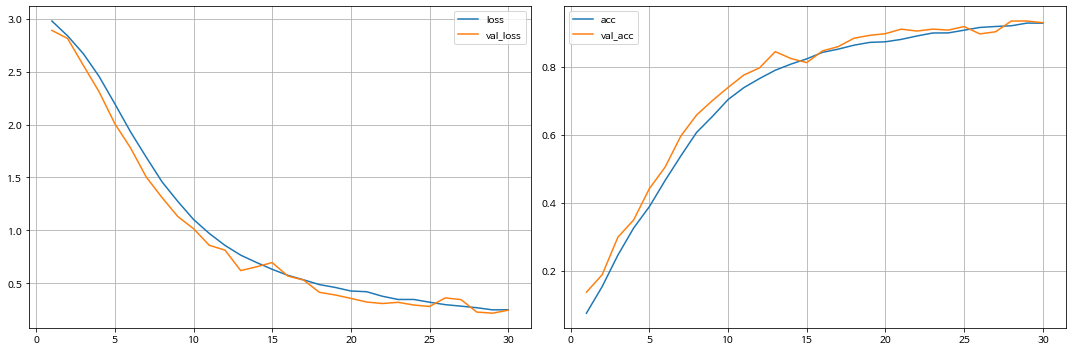

178/178 [==============================] - 156s 875ms/step - loss: 0.2496 - acc: 0.9283 - val_loss: 0.2448 - val_acc: 0.9297


In [ ]:
efnv2b0_model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

model_name = '/content/drive/MyDrive/Car-model-classification/models/efnv2b0_car_front_model.h5'
checkpoint_cb = ModelCheckpoint(model_name, save_best_only=True)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = efnv2b0_model.fit_generator(
    train_front_images,
    epochs=epochs,
    validation_data=val_front_images,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_cb, early_stopping_cb, PlotLearning()]
)

### Results

#### plot accuracy & loss

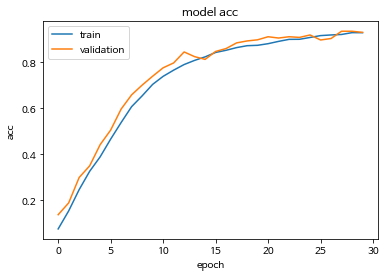

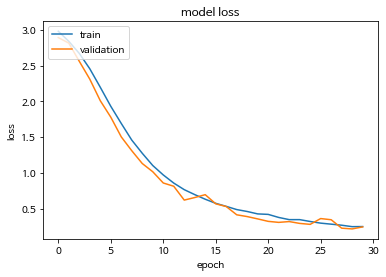

In [ ]:
plot_hist(history, 'acc')
plot_hist(history, 'loss')

#### test accuracy

In [ ]:
# test image set 결과
results = efnv2b0_model.evaluate(test_front_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 93.99%


#### Heatmap
실제 label과 해당 사진을 모델이 예측한 결과

27/27 [==============================] - 8s 240ms/step


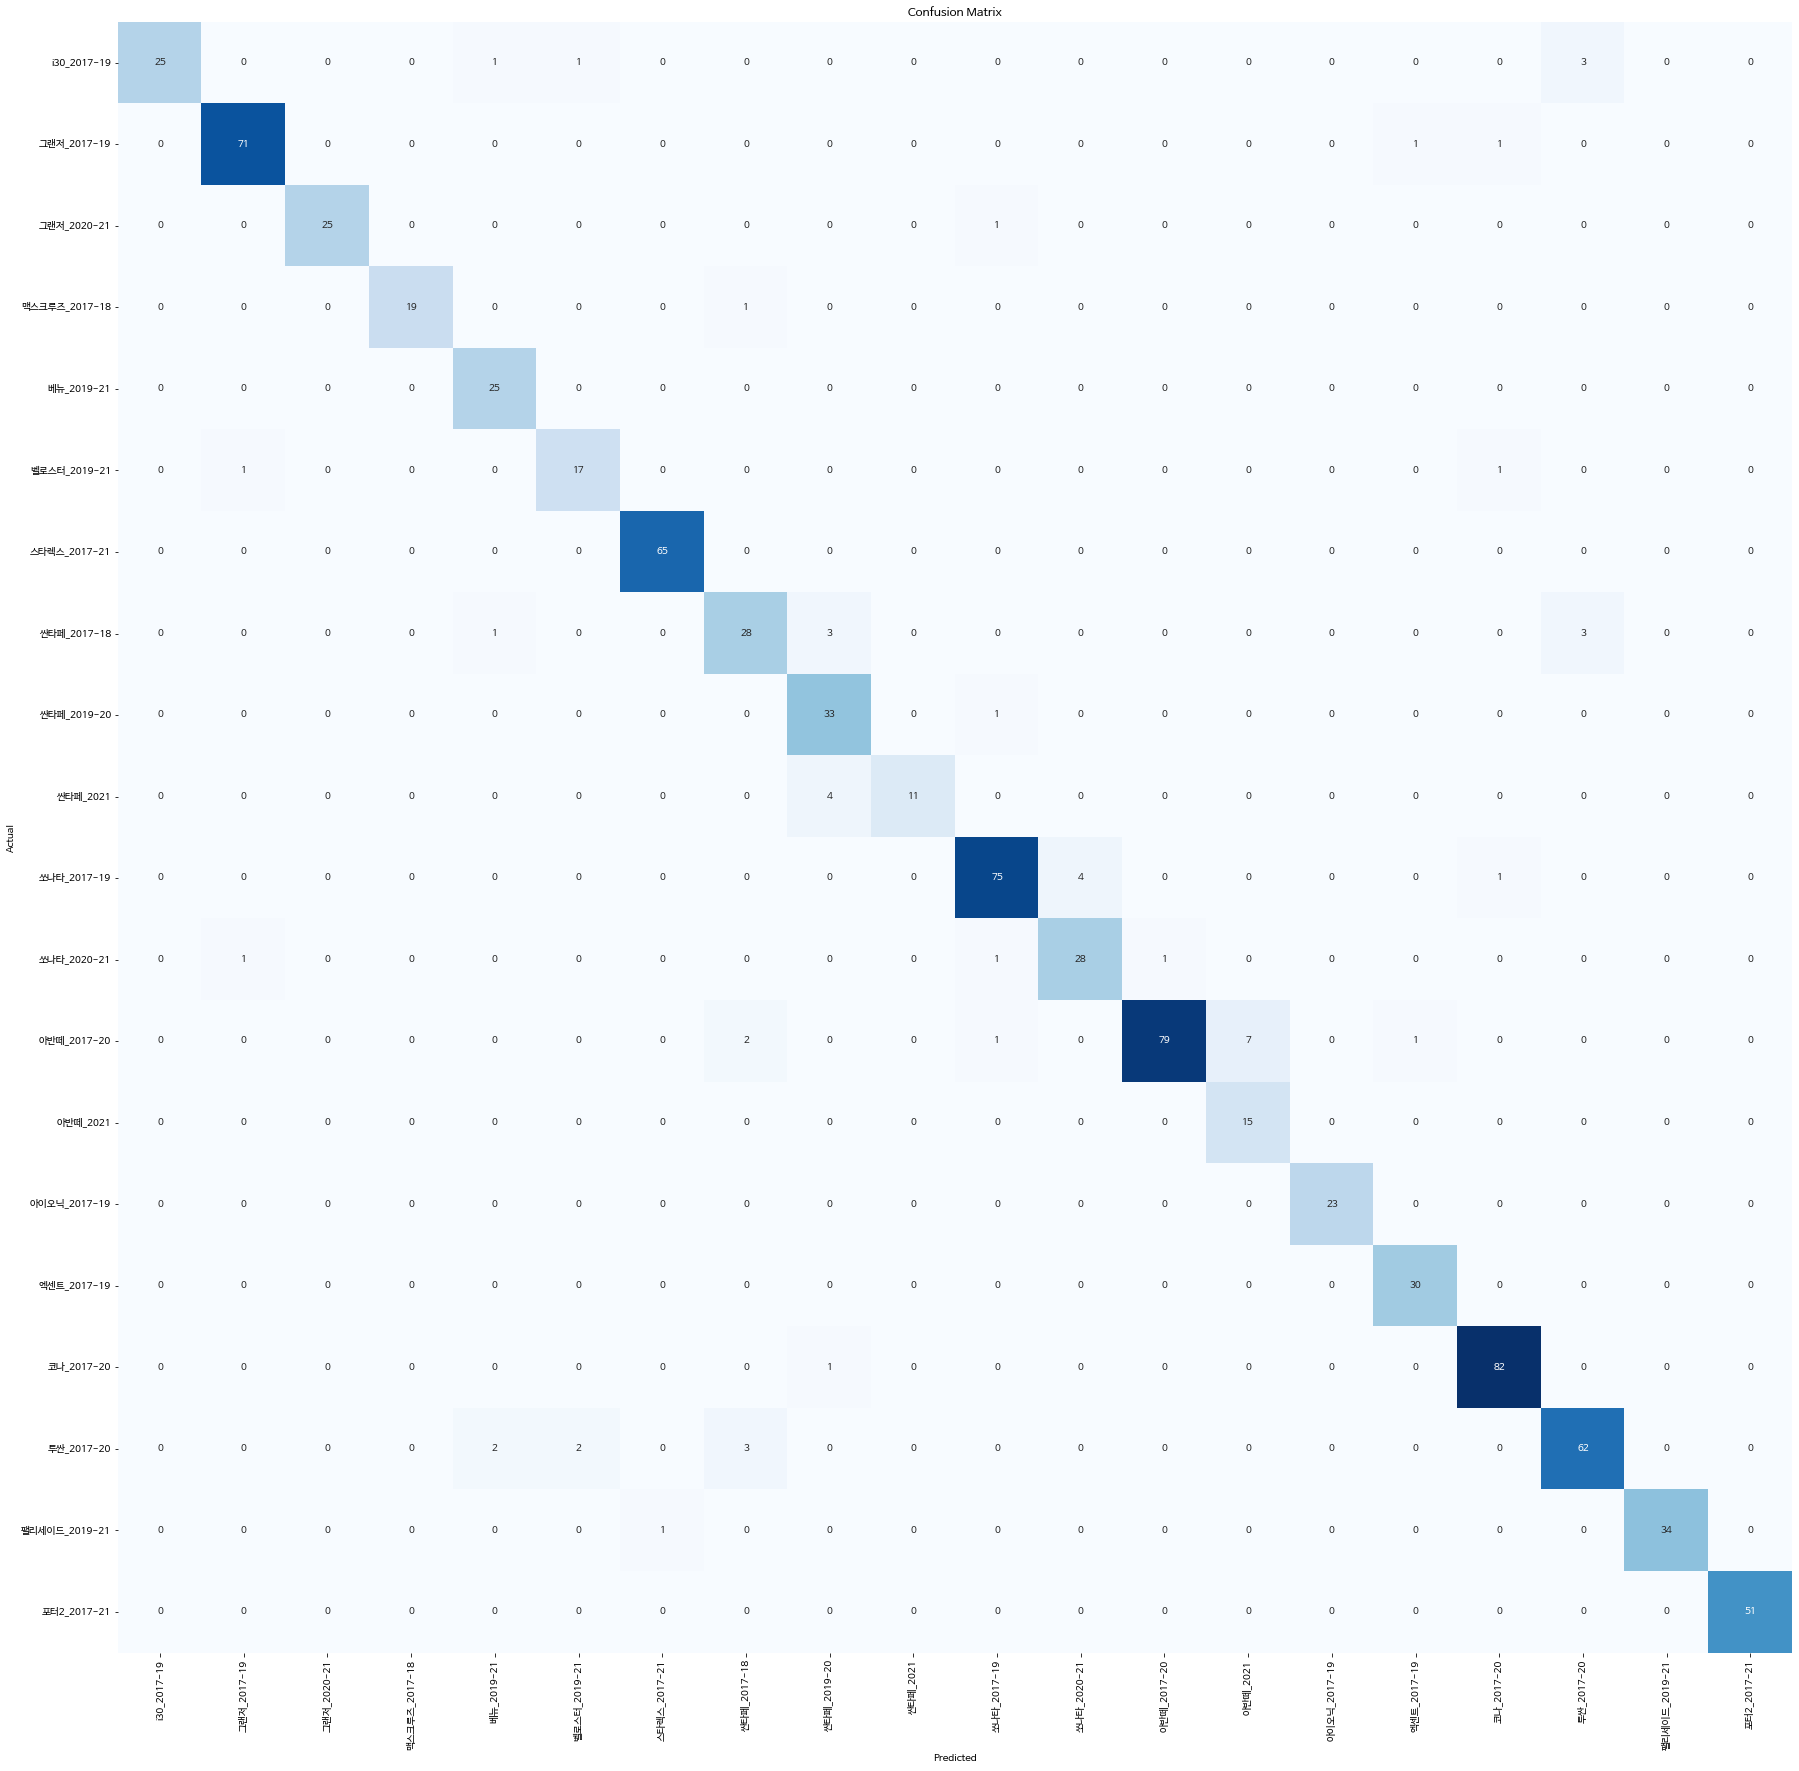

In [ ]:
plot_heatmap(efnv2b0_model, test_front_images, front_class_num)

## efficientnetv2S car front images

### Hyper parameters

https://pypi.org/project/keras-efficientnet-v2/

In [ ]:
front_class_num = 20
batch_size = 32

width = 384
height = 384
epochs = 30
dropout_rate = 0.2
input_shape = (height, width, 3)

### image dataset

In [ ]:
train_front_images, val_front_images, test_front_images = generate_dataset(train_front_df, val_front_df, test_front_df)

Found 5691 validated image filenames belonging to 20 classes.
Found 1422 validated image filenames belonging to 20 classes.
Found 849 validated image filenames belonging to 20 classes.


### load the conv base model (efficientNetV2S)

In [ ]:
inputs = tf.keras.Input(shape = input_shape)
x = tf.keras.applications.EfficientNetV2S(include_top = False, weights = 'imagenet')(inputs)
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dropout(dropout_rate, name="dropout_out")(x)
outputs = layers.Dense(front_class_num, activation='softmax', name="fc_out")(x)

efnv2S_model = tf.keras.Model(inputs, outputs)

82420632/82420632 [==============================] - 3s 0us/step


In [ ]:
efnv2S_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 gap (GlobalAveragePooling2D  (None, 1280)             0         
 )                                                               
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 20)                25620     
                                                                 
Total params: 20,356,980
Trainable params: 20,203,108
Non-t

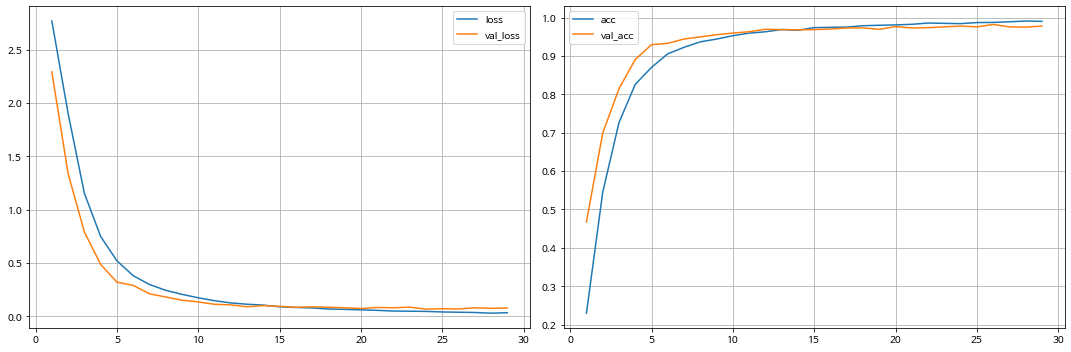

178/178 [==============================] - 352s 2s/step - loss: 0.0343 - acc: 0.9905 - val_loss: 0.0789 - val_acc: 0.9782


In [ ]:
efnv2S_model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

model_name = '/content/drive/MyDrive/Car-model-classification/models/efnv2S_car_front_model.h5'
checkpoint_cb = ModelCheckpoint(model_name, save_best_only=True)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = efnv2S_model.fit_generator(
    train_front_images,
    epochs=epochs,
    validation_data=val_front_images,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_cb, early_stopping_cb, PlotLearning()]
)

### Results

#### plot accuracy & loss

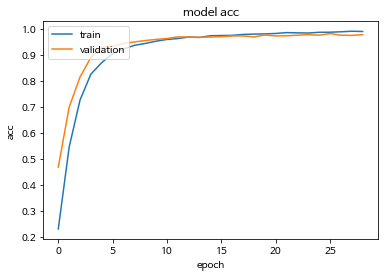

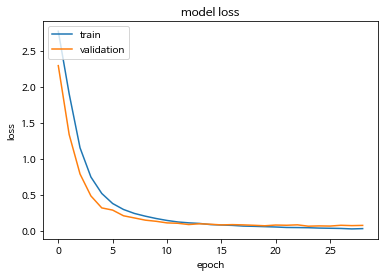

In [ ]:
plot_hist(history, 'acc')
plot_hist(history, 'loss')

#### test accuracy

In [ ]:
# test image set 결과
results = efnv2S_model.evaluate(test_front_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 96.70%


#### Heatmap
실제 label과 해당 사진을 모델이 예측한 결과

27/27 [==============================] - 11s 289ms/step


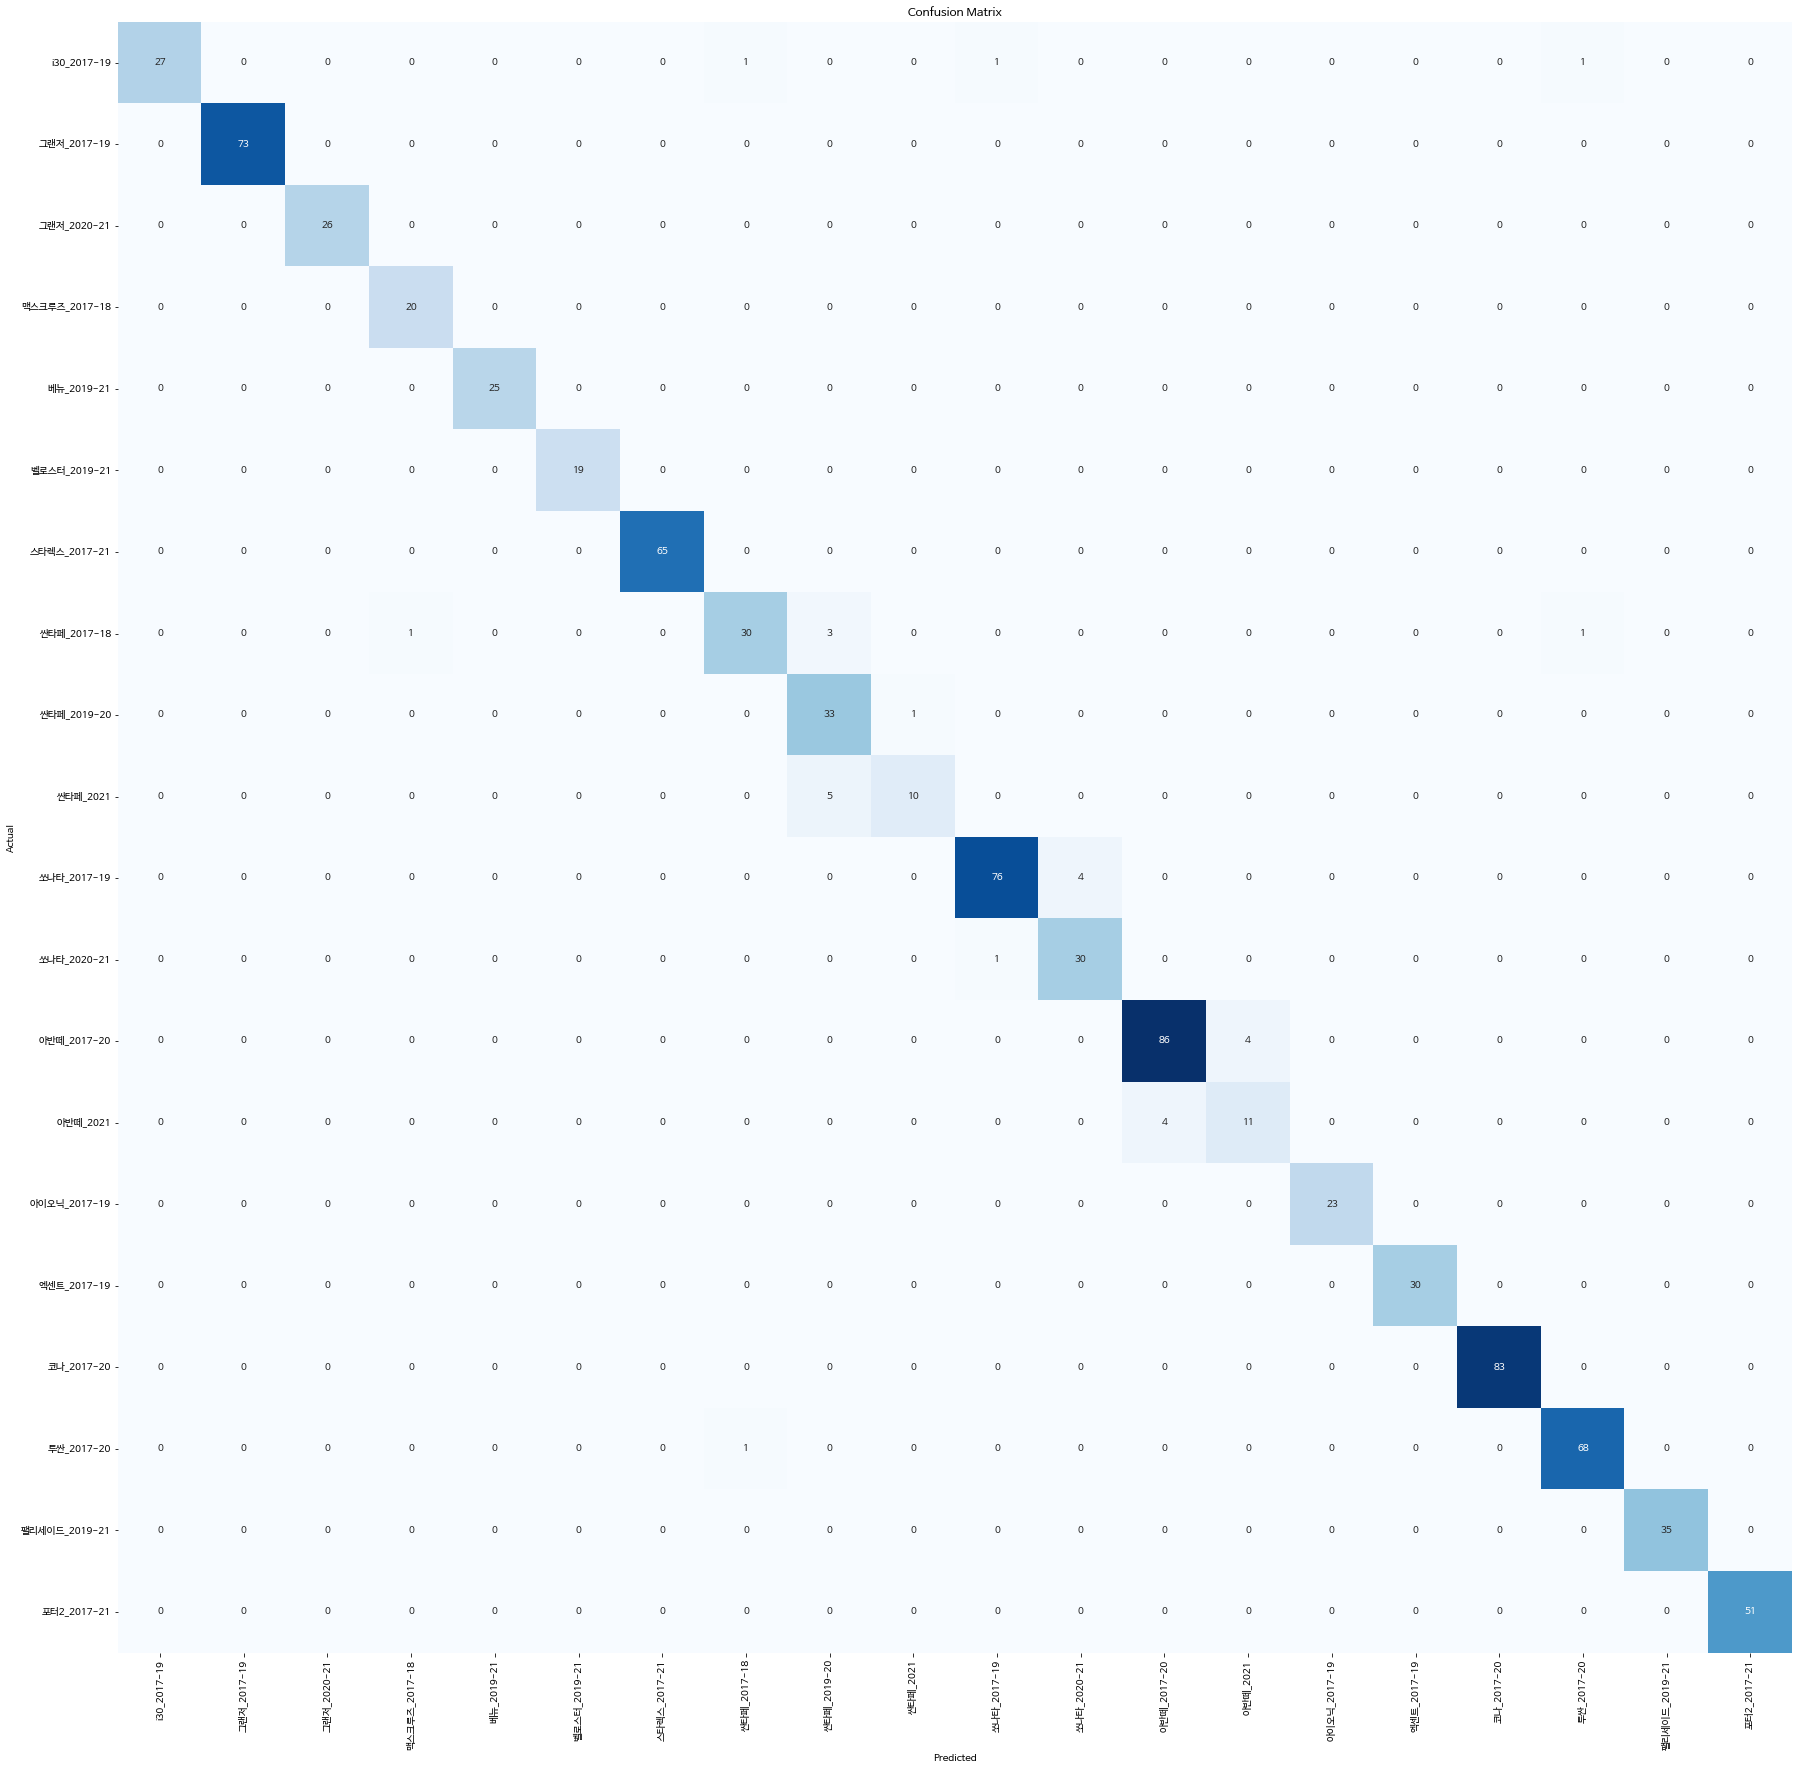

In [ ]:
plot_heatmap(efnv2S_model, test_front_images, front_class_num)

# car side, back(efficientnetv2S)

## efficientnetv2S car side images

### Hyper parameters

https://pypi.org/project/keras-efficientnet-v2/

In [ ]:
side_class_num = 20
batch_size = 32

width = 384
height = 384
epochs = 30
dropout_rate = 0.2
input_shape = (height, width, 3)

### image dataset

In [ ]:
train_side_images, val_side_images, test_side_images = generate_dataset(train_side_df, val_side_df, test_side_df)

Found 5201 validated image filenames belonging to 20 classes.
Found 1296 validated image filenames belonging to 20 classes.
Found 861 validated image filenames belonging to 20 classes.


### load the conv base model (efficientNetV2S)

In [ ]:
inputs = tf.keras.Input(shape = input_shape)
x = tf.keras.applications.EfficientNetV2S(include_top = False, weights = 'imagenet')(inputs)
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dropout(dropout_rate, name="dropout_out")(x)
outputs = layers.Dense(side_class_num, activation='softmax', name="fc_out")(x)

efnv2S_model = tf.keras.Model(inputs, outputs)

In [ ]:
efnv2S_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 gap (GlobalAveragePooling2D  (None, 1280)             0         
 )                                                               
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 20)                25620     
                                                                 
Total params: 20,356,980
Trainable params: 20,203,108
Non-t

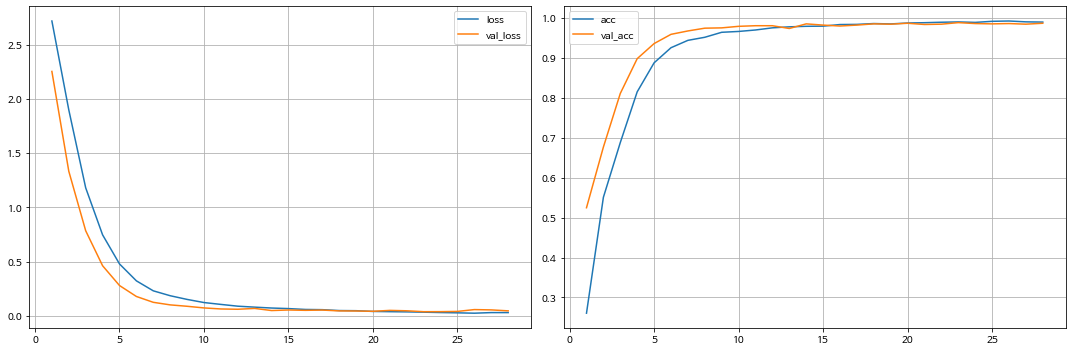

163/163 [==============================] - 319s 2s/step - loss: 0.0286 - acc: 0.9898 - val_loss: 0.0446 - val_acc: 0.9869


In [ ]:
efnv2S_model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

model_name = '/content/drive/MyDrive/Car-model-classification/models/efnv2S_car_side_model.h5'
checkpoint_cb = ModelCheckpoint(model_name, save_best_only=True)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = efnv2S_model.fit_generator(
    train_side_images,
    epochs=epochs,
    validation_data=val_side_images,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_cb, early_stopping_cb, PlotLearning()]
)

### Results

#### plot accuracy & loss

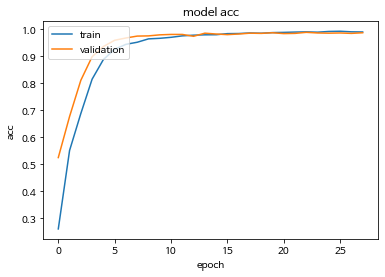

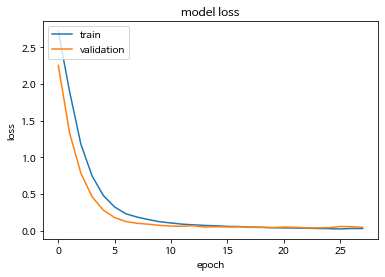

In [ ]:
plot_hist(history, 'acc')
plot_hist(history, 'loss')

#### test accuracy

In [ ]:
# test image set 결과
results = efnv2S_model.evaluate(test_side_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 97.56%


#### Heatmap
실제 label과 해당 사진을 모델이 예측한 결과

27/27 [==============================] - 12s 365ms/step


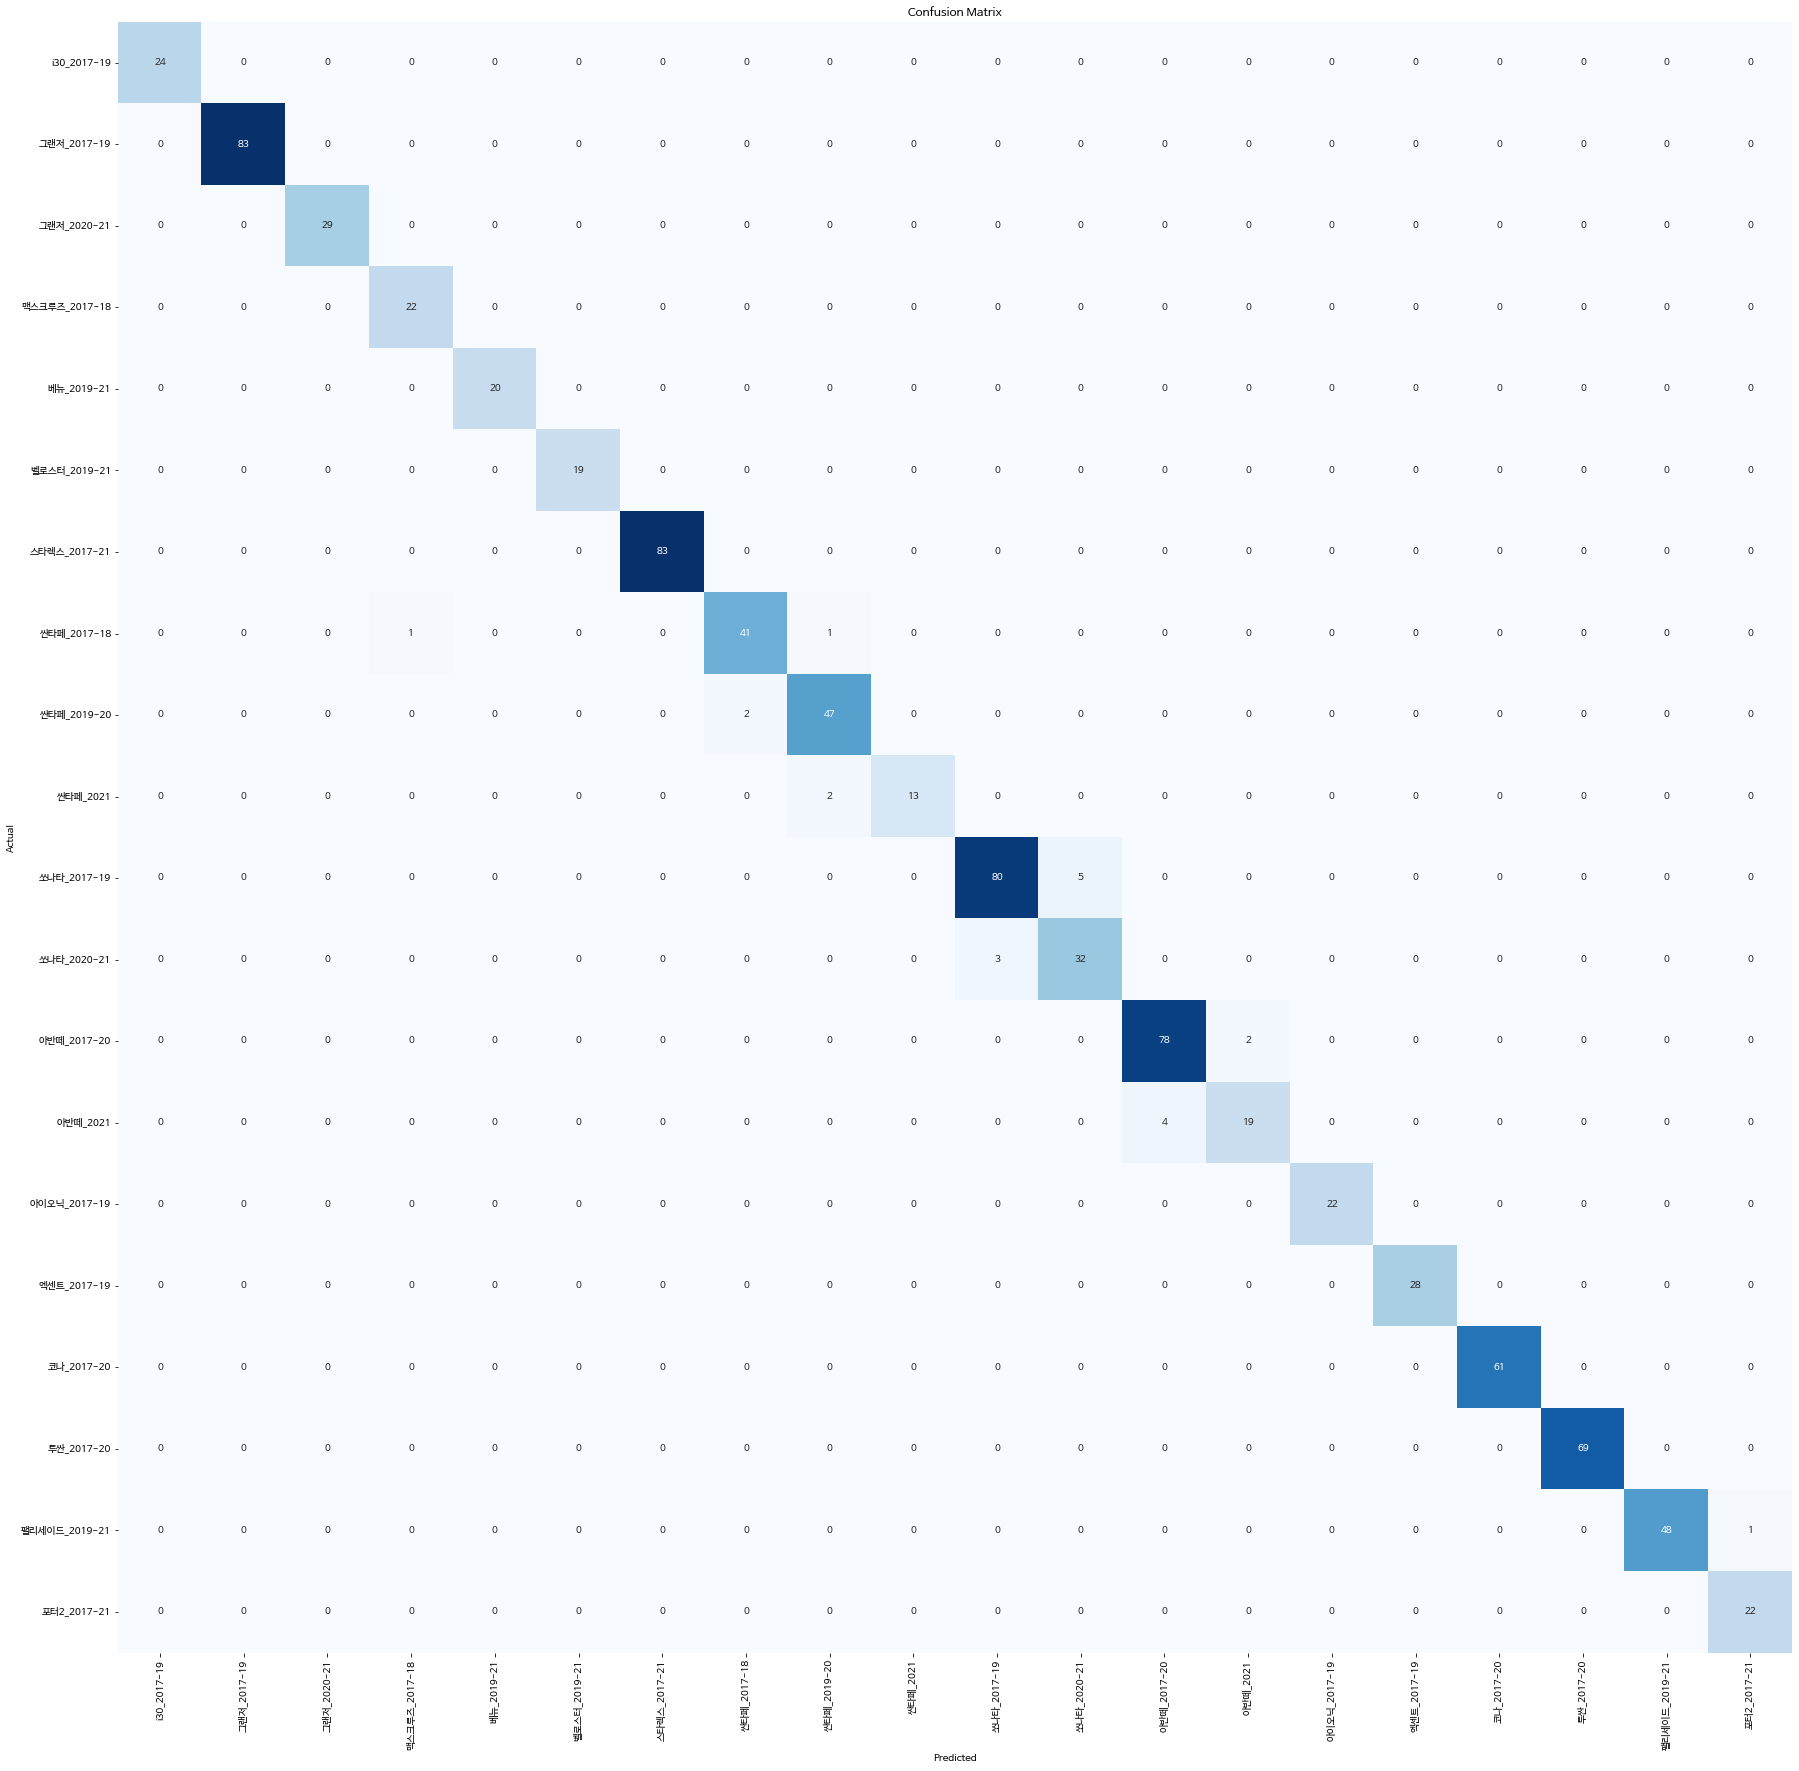

In [ ]:
plot_heatmap(efnv2S_model, test_side_images, side_class_num)

## efficientnetv2S car back images

### Hyper parameters

https://pypi.org/project/keras-efficientnet-v2/

In [ ]:
back_class_num = 19
batch_size = 32

width = 384
height = 384
epochs = 30
dropout_rate = 0.2
input_shape = (height, width, 3)

### image dataset

In [ ]:
train_back_images, val_back_images, test_back_images = generate_dataset(train_back_df, val_back_df, test_back_df)

Found 4949 validated image filenames belonging to 19 classes.
Found 1238 validated image filenames belonging to 19 classes.
Found 801 validated image filenames belonging to 19 classes.


### load the conv base model (efficientNetV2S)

In [ ]:
inputs = tf.keras.Input(shape = input_shape)
x = tf.keras.applications.EfficientNetV2S(include_top = False, weights = 'imagenet')(inputs)
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dropout(dropout_rate, name="dropout_out")(x)
outputs = layers.Dense(back_class_num, activation='softmax', name="fc_out")(x)

efnv2S_model = tf.keras.Model(inputs, outputs)

82420632/82420632 [==============================] - 0s 0us/step


In [ ]:
efnv2S_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 260, 260, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 gap (GlobalAveragePooling2D  (None, 1280)             0         
 )                                                               
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 19)                24339     
                                                                 
Total params: 20,355,699
Trainable params: 20,201,827
Non-tra

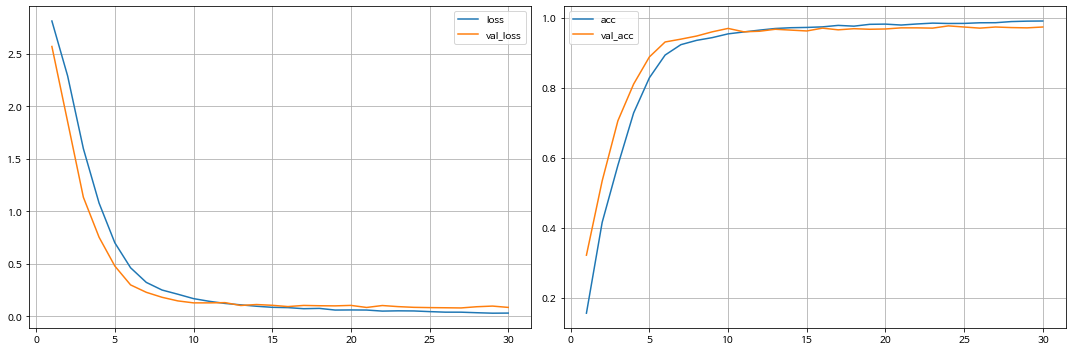

155/155 [==============================] - 173s 1s/step - loss: 0.0313 - acc: 0.9913 - val_loss: 0.0853 - val_acc: 0.9742


In [ ]:
efnv2S_model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

model_name = '/content/drive/MyDrive/Car-model-classification/models/efnv2S_car_back_model.h5'
checkpoint_cb = ModelCheckpoint(model_name, save_best_only=True)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = efnv2S_model.fit_generator(
    train_back_images,
    epochs=epochs,
    validation_data=val_back_images,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_cb, early_stopping_cb, PlotLearning()]
)

### Results

#### plot accuracy & loss

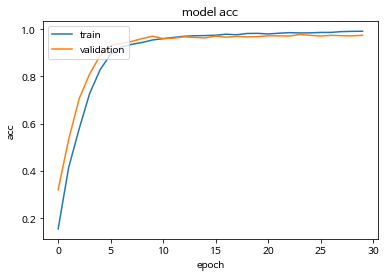

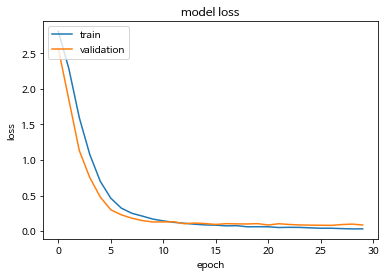

In [ ]:
plot_hist(history, 'acc')
plot_hist(history, 'loss')

#### test accuracy

In [ ]:
# test image set 결과
results = efnv2S_model.evaluate(test_back_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 97.00%


#### Heatmap
실제 label과 해당 사진을 모델이 예측한 결과

26/26 [==============================] - 10s 276ms/step


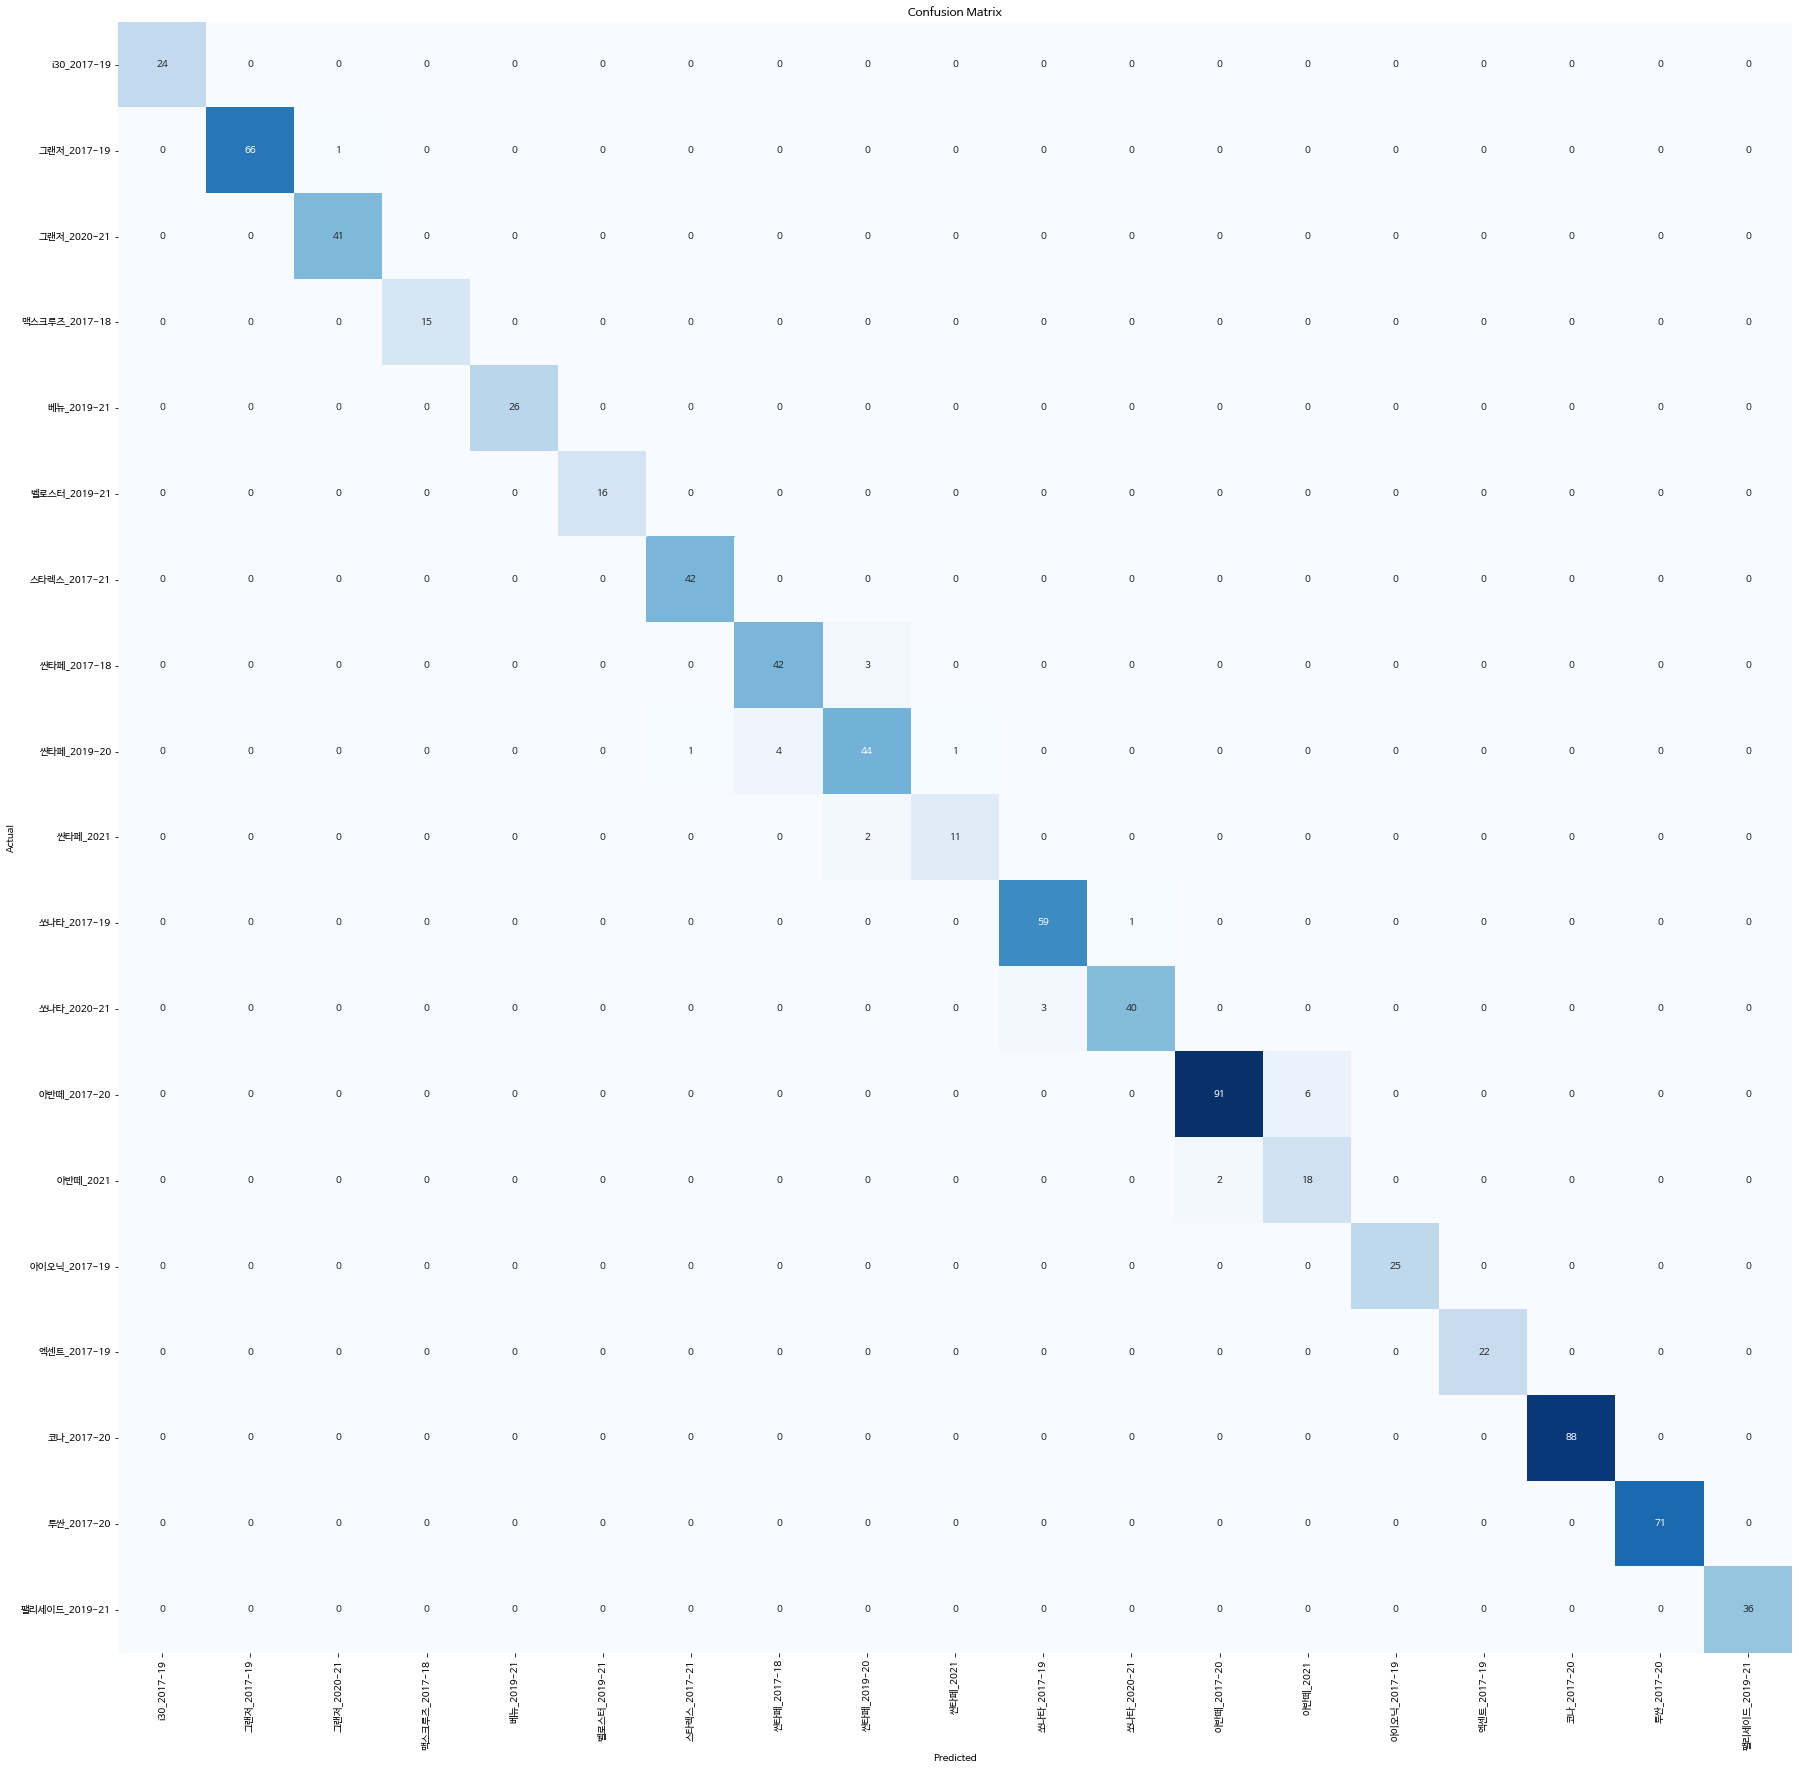

In [ ]:
plot_heatmap(efnv2S_model, test_back_images, back_class_num)

#### Class Activation Map(CAM)

In [ ]:
efnv2S_front_model = tf.keras.models.load_model('/content/drive/MyDrive/Car-model-classification/models/efnv2S_car_front_model.h5')
efnv2S_side_model = tf.keras.models.load_model('/content/drive/MyDrive/Car-model-classification/models/efnv2S_car_side_model.h5')
efnv2S_back_model = tf.keras.models.load_model('/content/drive/MyDrive/Car-model-classification/models/efnv2S_car_back_model.h5')

In [ ]:
for img, lbl in test_front_images.take(5):
    print(f"ground truth: {'dog' if lbl else 'cat'}")
    features,results = efnv2b0_model.predict(img)
    show_cam(img, features, results, lbl)